In [1]:
import os
import logging
import warnings
import math

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import net.net as net
import net.io as io
import training.training as training

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Configure root logger to show logs from all imported modules
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Remove any existing handlers to avoid duplicate logs
for handler in root_logger.handlers[:]:
    root_logger.removeHandler(handler)

# Add a stream handler with formatting
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root_logger.addHandler(handler)

# Also configure this module's logger
logger = logging.getLogger(__name__)

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# --- Configuration ---
# Define parameter ranges for the grid search
DATA_PATH_SUFFIXES_TO_TEST = ["", "_10000", "_20000", "_30000"]
BATCH_SIZES_TO_TEST = [256, 512, 1024, 2048, 4096]
NUM_WORKERS_TO_TEST = [2, 4, 8, 16]

BASE_DATA_PATH = "./training" # <--- ADJUST THIS PATH

# *** IMPORTANT: Set a batch limit for initial testing ***
# Process N batches per epoch instead of the full dataset. Speeds up search significantly.
# Set to None to process the full estimated length of the dataset per epoch.
INITIAL_BATCH_LIMIT = 100 # Start with a small number like 50 or 100

EPOCH_TIMING_LIMIT = 1 # Number of times to iterate through the limited batches for timing

# Initialize model
MODEL = net.ExpandedGlideatorNet(
    weather_scaler=io.load_net('training/models/weather_scaler.pth'),
    site_scaler=io.load_net('training/models/site_scaler.pth'),
    num_launches=251,  # Get this from your data
    num_targets=11,  # For XC thresholds
    site_embedding_dim=32,
    deep_hidden_units=[128, 64, 32],
    cross_layers=2
)
CRITERION = torch.nn.BCELoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=0.001)

# --- Pre-run Checks ---
print("--- Configuration ---")
print(f"Base Data Path: {os.path.abspath(BASE_DATA_PATH)}")
print(f"Data Suffixes: {DATA_PATH_SUFFIXES_TO_TEST}")
print(f"Batch Sizes: {BATCH_SIZES_TO_TEST}")
print(f"Num Workers: {NUM_WORKERS_TO_TEST}")
print(f"Batches per Epoch Limit: {INITIAL_BATCH_LIMIT}")
print(f"Timing Epochs: {EPOCH_TIMING_LIMIT}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# Basic check if the first expected data path exists
if DATA_PATH_SUFFIXES_TO_TEST:
    first_train_path = os.path.join(BASE_DATA_PATH, f"train_data{DATA_PATH_SUFFIXES_TO_TEST[0]}")
    if not os.path.isdir(first_train_path):
            print(f"\nWARNING: The first expected training data path does not exist:")
            print(f"  {os.path.abspath(first_train_path)}")
            print(f"Please ensure BASE_DATA_PATH ('{BASE_DATA_PATH}') and DATA_PATH_SUFFIXES_TO_TEST are correct.")
            # Exit if essential path is missing? Or let the function handle it.
            # import sys
            # sys.exit("Exiting due to missing data path.")
    else:
        print(f"\nFound first expected train path: {os.path.abspath(first_train_path)}")
        print("Starting grid search...")
else:
    print("\nERROR: No data path suffixes specified in DATA_PATH_SUFFIXES_TO_TEST.")
    import sys
    sys.exit("Exiting.")

# --- Run Search ---
optimal_settings = training.find_optimal_dataloader_params(
    base_data_path=BASE_DATA_PATH,
    data_path_suffixes=DATA_PATH_SUFFIXES_TO_TEST,
    batch_sizes=BATCH_SIZES_TO_TEST,
    num_workers_list=NUM_WORKERS_TO_TEST,
    epoch_limit=EPOCH_TIMING_LIMIT,
    batches_limit=INITIAL_BATCH_LIMIT,
    model=MODEL,
    criterion=CRITERION,
    optimizer=OPTIMIZER
)

2025-05-06 21:34:51,090 - net.io - INFO - Loading neural network model from training/models/weather_scaler.pth
2025-05-06 21:34:51,254 - net.io - INFO - Neural network model successfully loaded from training/models/weather_scaler.pth
2025-05-06 21:34:51,255 - net.io - INFO - Loading neural network model from training/models/site_scaler.pth
2025-05-06 21:34:51,263 - net.io - INFO - Neural network model successfully loaded from training/models/site_scaler.pth
2025-05-06 21:34:51,452 - training.training - INFO - Starting grid search over 80 parameter combinations...
2025-05-06 21:34:51,453 - training.training - INFO - --- Testing combination 1/80: {'suffix': '', 'batch_size': 256, 'num_workers': 2} ---
/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or

--- Configuration ---
Base Data Path: /mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/training
Data Suffixes: ['', '_10000', '_20000', '_30000']
Batch Sizes: [256, 512, 1024, 2048, 4096]
Num Workers: [2, 4, 8, 16]
Batches per Epoch Limit: 100
Timing Epochs: 1
CUDA Available: False

Found first expected train path: /mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/training/train_data
Starting grid search...


2025-05-06 21:34:54,136 - training.training - INFO -   Warmup completed 3 batches.
2025-05-06 21:34:54,139 - training.training - INFO -   Epoch 1/1: Processing up to 100 batches...
2025-05-06 21:35:28,730 - training.training - INFO -   Epoch 1 completed in 34.593s. Processed 25600 samples in 100 batches.
2025-05-06 21:35:28,731 - training.training - INFO -   Avg Throughput for {'suffix': '', 'batch_size': 256, 'num_workers': 2}: 740.04 samples/sec
2025-05-06 21:35:28,732 - training.training - INFO -   >>> New best throughput found: 740.04 samples/sec <<<
2025-05-06 21:35:29,734 - training.training - INFO - --- Testing combination 2/80: {'suffix': '', 'batch_size': 256, 'num_workers': 4} ---
2025-05-06 21:35:29,752 - training.training - INFO -   Running up to 3 warmup batches for {'suffix': '', 'batch_size': 256, 'num_workers': 4}...
2025-05-06 21:35:31,234 - training.training - INFO -   Warmup completed 3 batches.
2025-05-06 21:35:31,236 - training.training - INFO -   Epoch 1/1: Proces

In [6]:
# --- Print Results ---
print("\n--- Grid Search Results ---")
if optimal_settings and optimal_settings.get("best_params"):
    print(f"\nOptimal Settings Found:")
    print(f"  Best Parameters: {optimal_settings['best_params']}")
    print(f"  Max Throughput: {optimal_settings['max_throughput']:.2f} samples/sec")

    print("\n--- All Results (Sorted by Throughput Descending) ---")
    # Sort results for clarity, handling potential None throughputs
    sorted_results = sorted(
        optimal_settings['all_results'],
        key=lambda x: x.get('throughput', 0) if x.get('throughput') is not None else 0,
        reverse=True
    )
    for res in sorted_results:
            throughput_str = f"{res.get('throughput', 'N/A'):.2f}" if isinstance(res.get('throughput'), (int, float)) else "N/A"
            error_str = f" (Error: {res.get('error', 'Unknown')})" if res.get('error') else ""
            print(f"  Params: {res['params']}, Throughput: {throughput_str} samples/sec{error_str}")

elif optimal_settings: # Case where search ran but found no valid throughput > 0
        print("\nGrid search completed, but no combination yielded successful throughput.")
        print("\n--- All Results ---")
        for res in optimal_settings.get('all_results', []):
            throughput_str = f"{res.get('throughput', 'N/A'):.2f}" if isinstance(res.get('throughput'), (int, float)) else "N/A"
            error_str = f" (Error: {res.get('error', 'Unknown')})" if res.get('error') else ""
            print(f"  Params: {res['params']}, Throughput: {throughput_str} samples/sec{error_str}")
else: # Case where the function itself returned None (shouldn't happen with current logic)
    print("\nGrid search function did not return results.")


--- Grid Search Results ---

Optimal Settings Found:
  Best Parameters: {'suffix': '_30000', 'batch_size': 2048, 'num_workers': 8}
  Max Throughput: 1475.06 samples/sec

--- All Results (Sorted by Throughput Descending) ---
  Params: {'suffix': '_30000', 'batch_size': 2048, 'num_workers': 8}, Throughput: 1475.06 samples/sec
  Params: {'suffix': '_20000', 'batch_size': 2048, 'num_workers': 8}, Throughput: 1471.37 samples/sec
  Params: {'suffix': '_20000', 'batch_size': 1024, 'num_workers': 8}, Throughput: 1468.09 samples/sec
  Params: {'suffix': '', 'batch_size': 1024, 'num_workers': 8}, Throughput: 1464.32 samples/sec
  Params: {'suffix': '_10000', 'batch_size': 2048, 'num_workers': 8}, Throughput: 1460.66 samples/sec
  Params: {'suffix': '_10000', 'batch_size': 1024, 'num_workers': 8}, Throughput: 1386.47 samples/sec
  Params: {'suffix': '_30000', 'batch_size': 1024, 'num_workers': 8}, Throughput: 1353.78 samples/sec
  Params: {'suffix': '_10000', 'batch_size': 4096, 'num_workers': 4

In [7]:
df_temp = pd.DataFrame(optimal_settings['all_results'])
params_df = pd.json_normalize(df_temp['params'])
res_df = pd.concat([params_df, df_temp['throughput']], axis=1)



In [8]:
def isolation_plot(df: pd.DataFrame, result_col: str, param_col: str, ax=None):
    """
    Plots the maximum of result_col for each unique value in param_col.
    If ax is provided, plots on that axis. Otherwise, creates a new figure and shows the plot.

    Args:
        df (pd.DataFrame): The input DataFrame.
        result_col (str): The name of the column to aggregate (get the max value from).
        param_col (str): The name of the column to group by and use for the x-axis.
        ax (matplotlib.axes.Axes, optional): The axes object to plot on. Defaults to None.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(result_col, str) or result_col not in df.columns:
        raise ValueError(f"'{result_col}' is not a valid column name in the DataFrame.")
    if not isinstance(param_col, str) or param_col not in df.columns:
        raise ValueError(f"'{param_col}' is not a valid column name in the DataFrame.")

    agg_df = df.groupby(param_col, as_index=False)[result_col].max()

    create_new_figure = ax is None

    if create_new_figure:
        plt.figure(figsize=(10, 6))
        current_ax = plt.gca()
    else:
        current_ax = ax

    sns.barplot(x=param_col, y=result_col, data=agg_df, ax=current_ax)
    current_ax.set_title(f'Max of {result_col} by {param_col}')
    current_ax.set_xlabel(param_col)
    current_ax.set_ylabel(f'Max({result_col})')

    # Rotate and align x-tick labels
    current_ax.tick_params(axis='x', rotation=45)
    plt.setp(current_ax.get_xticklabels(), ha='right', rotation_mode="anchor")


    if create_new_figure:
        plt.tight_layout()
        plt.show()

def all_isolation_plots(df: pd.DataFrame, result_col: str, params_cols: list[str]):
    """
    Generates isolation plots for a list of parameter columns, arranging them
    in a single figure with two columns of charts.

    Args:
        df (pd.DataFrame): The input DataFrame.
        result_col (str): The name of the column to aggregate (get the max value from).
        params_cols (list[str]): A list of column names to plot against.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(result_col, str) or result_col not in df.columns:
        raise ValueError(f"'{result_col}' is not a valid column name in the DataFrame.")
    if not isinstance(params_cols, list) or not all(isinstance(p, str) for p in params_cols):
        raise ValueError("'params_cols' must be a list of strings.")
    for p_col in params_cols:
        if p_col not in df.columns:
            raise ValueError(f"Parameter column '{p_col}' is not a valid column name in the DataFrame.")

    num_params = len(params_cols)
    if num_params == 0:
        print("No parameters provided to plot.")
        return

    num_plot_cols = 2
    num_plot_rows = math.ceil(num_params / num_plot_cols)

    fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(14, num_plot_rows * 5), squeeze=False)
    
    axes_flat = axes.flatten()

    for i, param_col in enumerate(params_cols):
        current_ax = axes_flat[i]
        isolation_plot(df, result_col, param_col, ax=current_ax)

    for i in range(num_params, num_plot_rows * num_plot_cols):
        fig.delaxes(axes_flat[i])

    plt.tight_layout()
    plt.show()

2025-05-07 01:14:21,232 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-07 01:14:21,278 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-07 01:14:21,350 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-07 01:14:21,356 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


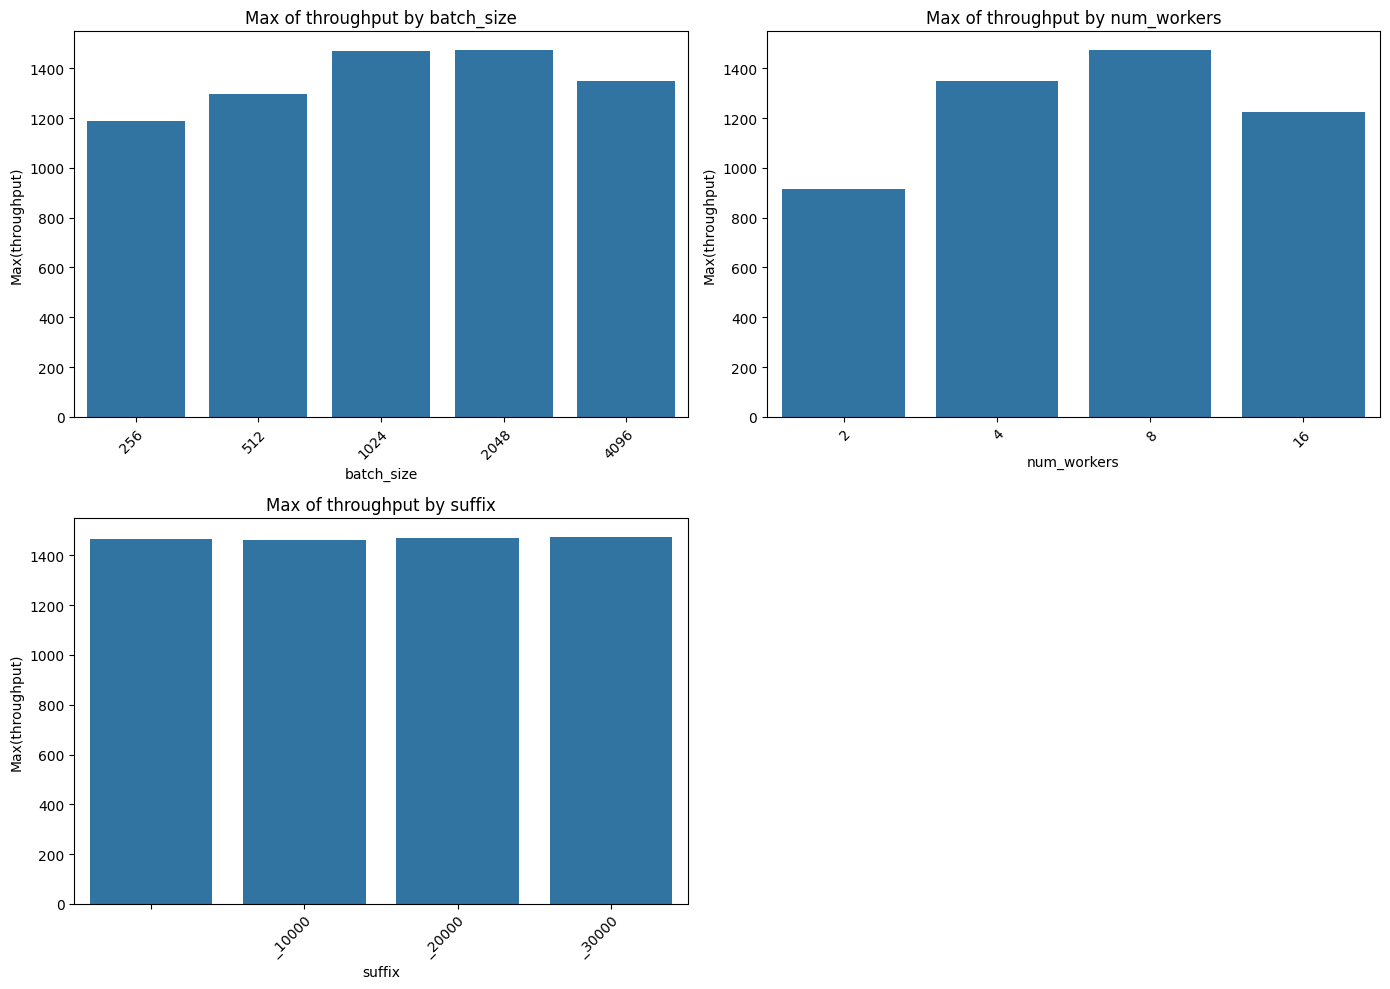

In [9]:
all_isolation_plots(res_df, 'throughput', ['batch_size', 'num_workers', 'suffix'])